# Tutorial 3 - Physics-Informed Neural Networks

One of the areas where KANs have found a lot of applications is PDE solving by replacing MLPs as the underlying architecture for Physics-Informed Neural Networks (PINNs).

In [15]:
import os
import sys

# Workaround to import jaxKAN
project_root = os.path.abspath("..")
sys.path.append(project_root)

from jaxkan.KAN import KAN

import jax
import jax.numpy as jnp

from jaxkan.utils.PIKAN import sobol_sample, gradf

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

## Data Generation

For the purposes of this example, we will be solving Burgers' Equation,

$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0,$$

for $\nu = \pi/100$ in the $\Omega = [0,1]\times [-1, 1]$ domain, subject to the boundary conditions

$$ u\left(t=0, x\right) = -\sin\left(\pi x\right), $$

$$ u\left(t, x=-1\right) = u\left(t, x=1\right) = 0. $$

To this end, we must first define appropriate collocation points. Note that in the following we are using the `sobol_sample` method from `jaxkan.utils.PIKAN`, to perform Sobol sampling for the collocation points used to enforce the PDE.

In [8]:
seed = 42

# Generate Collocation points for PDE
N = 2**12
collocs = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,1]), N, seed)) # (4096, 2)

# Generate Collocation points for BCs
N = 2**6

BC1_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([0,1]), N)) # (64, 2)
BC1_data = - jnp.sin(np.pi*BC1_colloc[:,1]).reshape(-1,1) # (64, 1)

BC2_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,-1]), N)) # (64, 2)
BC2_data = jnp.zeros(BC2_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC3_colloc = jnp.array(sobol_sample(np.array([0,1]), np.array([1,1]), N)) # (64, 2)
BC3_data = jnp.zeros(BC3_colloc.shape[0]).reshape(-1,1) # (64, 1)

# Create lists for BCs
bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc]
bc_data = [BC1_data, BC2_data, BC3_data]

## KAN Model

We covered KAN Model selection in the first tutorial, so feel free to refer to it for more info. For this example, we will be using a Modified Chebychev KAN Layer.

In [9]:
# Initialize a KAN model
n_in = collocs.shape[1]
n_out = 1
n_hidden = 6

layer_dims = [n_in, n_hidden, n_hidden, n_out]
req_params = {'k': 5}

model = KAN(layer_dims = layer_dims,
            layer_type = 'mod-cheby',
            required_parameters = req_params,
            add_bias = True,
            rngs = nnx.Rngs(seed)
           )

print(model)

KAN(
  add_bias=True,
  layer_type='mod-cheby',
  layers=[ModifiedChebyLayer(
    n_in=2,
    n_out=6,
    k=5,
    c_basis=Param(
      value=Array(shape=(6, 2, 6), dtype=float32)
    ),
    c_act=Param(
      value=Array(shape=(6, 2), dtype=float32)
    )
  ), ModifiedChebyLayer(
    n_in=6,
    n_out=6,
    k=5,
    c_basis=Param(
      value=Array(shape=(6, 6, 6), dtype=float32)
    ),
    c_act=Param(
      value=Array(shape=(6, 6), dtype=float32)
    )
  ), ModifiedChebyLayer(
    n_in=6,
    n_out=1,
    k=5,
    c_basis=Param(
      value=Array(shape=(1, 6, 6), dtype=float32)
    ),
    c_act=Param(
      value=Array(shape=(1, 6), dtype=float32)
    )
  )],
  biases=[Param(
    value=Array(shape=(6,), dtype=float32)
  ), Param(
    value=Array(shape=(6,), dtype=float32)
  ), Param(
    value=Array([0.], dtype=float32)
  )]
)


## Training

In [12]:
opt_type = optax.adam(learning_rate=0.001)

optimizer = nnx.Optimizer(model, opt_type)

This problem does not correspond to supervised training. We simply need to define a loss term that enforces the PDE as well as a loss term that enforces the boundary conditions. Note that we utilize the `gradf` method from `jaxkan.utils.PIKAN`, which provides a straightforward way of defining derivatives of arbitrary order for $u$.

In [16]:
# PDE Loss
def pde_loss(model, collocs):
    # Eq. parameter
    v = jnp.array(0.01/jnp.pi, dtype=float)

    def u(x):
        y = model(x)
        return y
        
    # Physics Loss Terms
    u_t = gradf(u, 0, 1)
    u_x = gradf(u, 1, 1)
    u_xx = gradf(u, 1, 2)
    
    # Residual
    pde_res = u_t(collocs) + model(collocs)*u_x(collocs) - v*u_xx(collocs)
    
    return pde_res

# Define train loop
@nnx.jit
def train_step(model, optimizer, collocs, bc_collocs, bc_data):

    def loss_fn(model):
        pde_res = pde_loss(model, collocs)
        total_loss = jnp.mean((pde_res)**2)

        # Boundary losses
        for idx, colloc in enumerate(bc_collocs):
            # Residual = Model's prediction - Ground Truth
            residual = model(colloc)
            residual -= bc_data[idx]
            # Loss
            total_loss += jnp.mean(residual**2)

        return total_loss
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    
    return loss

In [17]:
# Initialize train_losses
num_epochs = 5000
train_losses = jnp.zeros((num_epochs,))

for epoch in range(num_epochs):
    # Calculate the loss
    loss = train_step(model, optimizer, collocs, bc_collocs, bc_data)
    
    # Append the loss
    train_losses = train_losses.at[epoch].set(loss)

## Evaluation

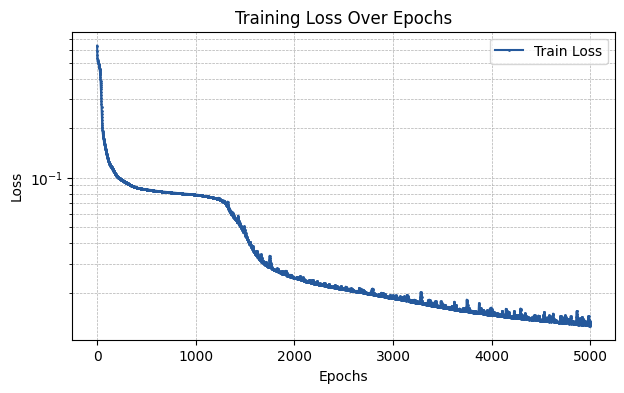

In [18]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

The following plot shows the trained neural network on the entire domain, approximating the solution, $u$, of the equation.

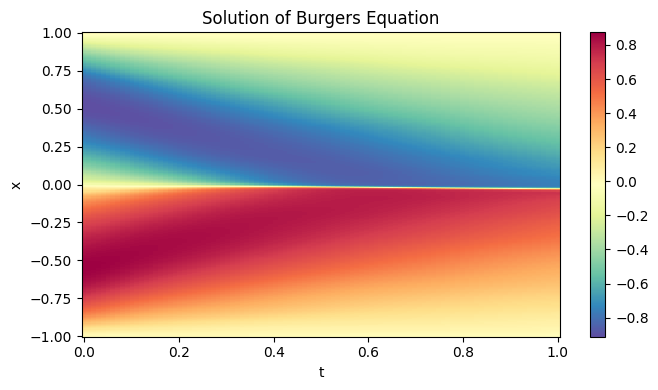

In [22]:
N_t, N_x = 100, 256

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(-1.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output = model(jnp.array(coords))
resplot = np.array(output).reshape(N_t, N_x)

plt.figure(figsize=(7, 4))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Solution of Burgers Equation')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()